In [1]:
import pandas as pd
import numpy as np
import fastsparsegams
np.random.seed(0)
df = pd.read_csv('/home/users/jcd97/code/joint_rashomon_importance/data/fico_full.csv')

In [2]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=20, stratify=df['PoorRiskPerformance'])

In [3]:
def binarize_according_to_train(train_df, test_df):
    n_train, d_train = train_df.shape
    n_test, d_test = test_df.shape
    train_binned, train_augmented_binned, test_binned, test_augmented_binned = {}, {}, {}, {}
    train_no_missing, test_no_missing = {}, {}
    bin_map = {}
    dataset_structure_map = {}
    thresh_vals = []
    cur_new_col_index = 0
    missing_inds = []
    for col_ind, c in enumerate(train_df.columns):
        quantiles = train_df[c][train_df[c] > -7].quantile([0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]).unique()
        bin_list = list(quantiles) + [-7, -8, -9]
        dataset_structure_map[c] = {}
        dataset_structure_map[c]['intercepts'] = {}
        dataset_structure_map[c]['bins'] = []

        if c == 'PoorRiskPerformance':
            continue
        for bin_ind, v in enumerate(bin_list):
            thresh_vals.append(v)
            bin_map[bin_ind] = col_ind
            if v in [-7, -8, -9]:
                dataset_structure_map[c]['intercepts'][v] = cur_new_col_index
                missing_inds.append(v)
                new_col_name = f'{c}_{v}'

                new_row_train = np.zeros(n_train)
                new_row_train[train_df[c] == v] = 1
                train_binned[new_col_name] = new_row_train
                train_augmented_binned[new_col_name] = new_row_train
                
                new_row_test = np.zeros(n_test)
                new_row_test[test_df[c] == v] = 1
                test_binned[new_col_name] = new_row_test
                test_augmented_binned[new_col_name] = new_row_test
            else:
                dataset_structure_map[c]['bins'] = dataset_structure_map[c]['bins'] + [cur_new_col_index]
                new_col_name = f'{c} <= {v}'

                new_row_train = np.zeros(n_train)
                new_row_train[train_df[c] <= v] = 1
                new_row_train[train_df[c] <= -5] = 0
                
                train_no_missing[new_col_name] = new_row_train
                train_binned[new_col_name] = new_row_train
                train_augmented_binned[new_col_name] = new_row_train
                
                new_row_test = np.zeros(n_test)
                new_row_test[test_df[c] <= v] = 1
                new_row_test[test_df[c] <= -5] = 0
                test_no_missing[new_col_name] = new_row_test
                test_binned[new_col_name] = new_row_test
                test_augmented_binned[new_col_name] = new_row_test
            cur_new_col_index += 1
    
    for c_outer in train_df.columns:
        dataset_structure_map[c_outer]['interactions'] = {}
        if c_outer == 'PoorRiskPerformance':
            continue
        for m_val in [-7, -8, -9]:
            for c_inner in train_df.columns:
                if c_inner == c_outer:
                    continue 
                
                if 'interactions' not in dataset_structure_map[c_inner]:
                    dataset_structure_map[c_inner]['interactions'] = {}
                if c_outer not in dataset_structure_map[c_inner]['interactions']:
                    dataset_structure_map[c_inner]['interactions'][c_outer] = {}
                if m_val not in dataset_structure_map[c_inner]['interactions'][c_outer]:
                    dataset_structure_map[c_inner]['interactions'][c_outer][m_val] = []

                quantiles = train_df[c_inner][train_df[c_inner] > -7].quantile([0.2, 0.4, 0.6, 0.8, 1]).unique()
                for v in quantiles:
                    if (v in [-7, -8, -9]) or c_inner == 'PoorRiskPerformance':
                        continue
                    else:
                        thresh_vals.append(v)
                        dataset_structure_map[c_inner]['interactions'][c_outer][m_val] = dataset_structure_map[c_inner]['interactions'][c_outer][m_val] + [cur_new_col_index]
                        new_col_name = f'{c_outer}_missing_{m_val} & {c_inner} <= {v}'

                        new_row_train = np.zeros(n_train)
                        new_row_train[(train_df[c_outer] == m_val) & (train_df[c_inner] <= v)] = 1
                        new_row_train[(train_df[c_outer] == m_val) & (train_df[c_inner] <= -5)] = 0
                        train_augmented_binned[new_col_name] = new_row_train

                        new_row_test = np.zeros(n_test)
                        new_row_test[(test_df[c_outer] == m_val) & (test_df[c_inner] <= v)] = 1
                        new_row_test[(test_df[c_outer] == m_val) & (test_df[c_inner] <= -5)] = 0
                        test_augmented_binned[new_col_name] = new_row_test
                        cur_new_col_index += 1
    train_binned['PoorRiskPerformance'] = train_df['PoorRiskPerformance']
    test_binned['PoorRiskPerformance'] = test_df['PoorRiskPerformance']
    train_no_missing['PoorRiskPerformance'] = train_df['PoorRiskPerformance']
    test_no_missing['PoorRiskPerformance'] = test_df['PoorRiskPerformance']
    train_augmented_binned['PoorRiskPerformance'] = train_df['PoorRiskPerformance']
    test_augmented_binned['PoorRiskPerformance'] = test_df['PoorRiskPerformance']
    return pd.DataFrame(train_no_missing), pd.DataFrame(train_binned), pd.DataFrame(train_augmented_binned), \
         pd.DataFrame(test_no_missing), pd.DataFrame(test_binned), pd.DataFrame(test_augmented_binned),\
        bin_map, missing_inds, dataset_structure_map, thresh_vals

In [4]:
train_no_missing, train_binned, train_binned_augmented, test_no_missing, test_binned, test_binned_augmented, bin_map, missing_inds, dataset_structure_map, thresh_vals = binarize_according_to_train(train_df, test_df)

X_indicator_train = train_binned[train_binned.columns[:-1]].values
y_train = train_binned['PoorRiskPerformance'].values

X_indicator_test = test_binned[test_binned.columns[:-1]].values
y_test = test_binned['PoorRiskPerformance'].values

X_no_missing_train = train_no_missing[train_no_missing.columns[:-1]].values
X_no_missing_test = test_no_missing[test_no_missing.columns[:-1]].values

X_aug_train = train_binned_augmented[train_binned_augmented.columns[:-1]].values
X_aug_test = test_binned_augmented[test_binned_augmented.columns[:-1]].values

In [5]:
class StepFunction:
    def __init__(self, x_list=[1, 2], y_list=[1, 2]):
        self.x_list = x_list
        self.y_list = y_list

    def add_cut(self, new_x, new_y):
        if new_x in self.x_list:
            x_arr = np.array(self.x_list)
            y_arr = np.array(self.y_list)

            y_arr[x_arr >= new_x] += new_y

            self.y_list = list(y_arr)
        else:
            x_argsort = np.array(self.x_list + [new_x]).argsort()
            x_arr = np.array(self.x_list + [new_x])[x_argsort]

            if np.array(self.y_list)[np.array(self.x_list) < new_x].shape[0] > 0:
                new_y_adjusted = np.array(self.y_list)[np.array(self.x_list) < new_x][-1] + new_y
            else:
                new_y_adjusted = new_y
            y_arr = np.array(self.y_list + [new_y_adjusted])[x_argsort]
            y_arr[x_arr > new_x] += new_y

            self.x_list = list(np.array(self.x_list + [new_x])[x_argsort])
            self.y_list = list(y_arr)

In [6]:
def get_curve(dataset_structure_map, thresh_vals, coefs,
             target_var='PercentTradesWBalance', missing_vars=(['ExternalRiskEstimate'], [-7]),
             inters=True):
    sf = StepFunction([], [])
    if target_var in missing_vars[0]:
        target_type_ind = missing_vars[0].index(target_var)
        target_type = missing_vars[1][target_type_ind]

        ind_of_interest = dataset_structure_map[target_var]['intercepts'][target_type]
        return StepFunction([-1], [coefs[ind_of_interest]])

            
    sf = StepFunction([], [])
    for b in dataset_structure_map[target_var]['bins']:
        sf.add_cut(thresh_vals[b], coefs[b])
    
    if inters:
        for other_var in dataset_structure_map[target_var]['interactions']:
            if other_var in missing_vars[0]:
                target_type_ind = missing_vars[0].index(other_var)
                target_type = missing_vars[1][target_type_ind]

                for b in dataset_structure_map[target_var]['interactions'][other_var][target_type]:
                    sf.add_cut(thresh_vals[b], coefs[b])

    return sf

coefs = np.zeros(len(thresh_vals))
coefs[2] = 3
coefs[454] = 2
sf = get_curve(dataset_structure_map, thresh_vals, coefs, target_var='PercentTradesWBalance', missing_vars=(['ExternalRiskEstimate'], [-7]))
print(sf.x_list, sf.y_list)

[40.0, 47.0, 50.0, 60.0, 67.0, 75.0, 83.0, 86.0, 100.0] [0.0, 0.0, 0.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]


In [7]:
from sklearn.linear_model import LogisticRegression
model_indicator = LogisticRegression(max_iter=1000).fit(X_aug_train, y_train)

In [8]:
coefs = model_indicator.coef_[0]
(coefs != 0).sum()

1277

In [9]:
lambda_grid = [[20, 15, 10, 7.5, 5, 4, 3, 2, 1.5, 1, 0.5, 0.1]]
model_indicator = fastsparsegams.fit(
    X_indicator_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", 
    max_support_size=40, algorithm="CDPSI", lambda_grid=lambda_grid, num_lambda=None, num_gamma=None
)

In [10]:
model_aug= fastsparsegams.fit(
    X_aug_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", max_support_size=40, 
    algorithm="CDPSI", lambda_grid=lambda_grid, num_lambda=None, num_gamma=None
)

In [16]:
def check_interesting_missingness(dataset_structure_map, coefs, inters=True):
    miss_cols = []
    miss_types = []
    for v in dataset_structure_map:
        if inters:
            for v_inter in dataset_structure_map[v]['interactions']:
                cur = dataset_structure_map[v]['interactions'][v_inter]
                for m_type in cur:
                    for val in cur[m_type]:
                        if coefs[val] != 0:
                            miss_cols.append(v_inter)
                            miss_types.append(m_type)
        for m_type in dataset_structure_map[v]['intercepts']:
            coef = dataset_structure_map[v]['intercepts'][m_type]
            if coefs[coef] != 0:
                miss_cols.append(v)
                miss_types.append(m_type)
    return miss_cols, miss_types

check_interesting_missingness(dataset_structure_map, coefs, inters=False)

([], [])

In [17]:
inters = True
if inters:
    coefs = model_aug.coeff(lambda_0=model_aug.lambda_0[0][6]).toarray().flatten()
else:
    coefs = model_indicator.coeff(lambda_0=model_indicator.lambda_0[0][3]).toarray().flatten() #first entry is intercept


inter = coefs[0]
coefs = coefs[1:]

possible_missing_vars = check_interesting_missingness(dataset_structure_map, coefs, inters=True)
print(possible_missing_vars)
print(len(possible_missing_vars[0]))

(['MSinceMostRecentDelq', 'MSinceMostRecentInqexcl7days'], [-7, -7])
2


In [18]:
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
missingness_sets = [p for p in powerset(zip(possible_missing_vars[0], possible_missing_vars[1]))]
missingness_sets

[(),
 (('MSinceMostRecentDelq', -7),),
 (('MSinceMostRecentInqexcl7days', -7),),
 (('MSinceMostRecentDelq', -7), ('MSinceMostRecentInqexcl7days', -7))]

In [19]:
missingness_sets = [p for p in powerset(zip(possible_missing_vars[0], possible_missing_vars[1]))]
shaped_missingness_sets = []
for s in missingness_sets:
    names = [cur[0] for cur in s]
    vals = [cur[1] for cur in s]
    shaped_missingness_sets.append((names, vals))

(['MSinceMostRecentDelq'], [-7])


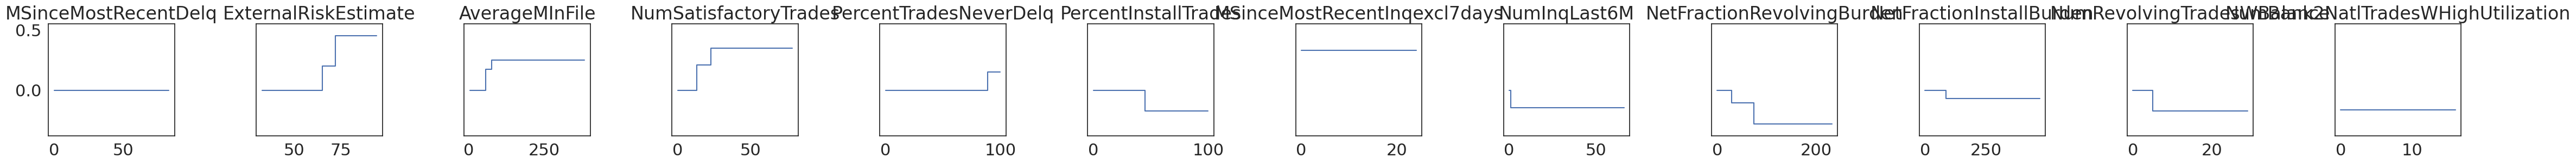

In [24]:
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
import os
os.makedirs('./gam_visualizations', exist_ok=True)
sns.set(font_scale=2.0)
sns.set_style(style='white')
inters = False
n_miss = 1
missing_vals = (possible_missing_vars[0][:n_miss], possible_missing_vars[1][:n_miss])
print(missing_vals)
n_interesting = 0
possible_active_vars = []
inter_vars = []
max_y = 0
min_y = 0


for var in dataset_structure_map:
    c = get_curve(dataset_structure_map, thresh_vals, coefs, target_var=var, missing_vars=missing_vals, inters=inters)
    if np.any(abs(np.array(c.y_list)) > 0):
        n_interesting += 1
        max_y = max(max_y, max(c.y_list))
        min_y = min(min_y, min(c.y_list))

    for m_set in shaped_missingness_sets:
        c = get_curve(dataset_structure_map, thresh_vals, coefs, target_var=var, missing_vars=m_set, inters=inters)
        if np.any(abs(np.array(c.y_list)) > 0):
            max_y = max(max_y, max(c.y_list))
            min_y = min(min_y, min(c.y_list))

        if np.any(abs(np.array(c.y_list)) > 0) and (var not in possible_active_vars):
            possible_active_vars.append(var)

fig, ax = plt.subplots(1, len(possible_active_vars), figsize=(len(possible_active_vars)*4, 5.5))
cur_i = 0
for loop_iter in range(2):
    for var in dataset_structure_map:
        if (loop_iter==0) and (var not in missing_vals[0]):
            continue
        elif (loop_iter==1) and (var in missing_vals[0]):
            continue

        c = get_curve(dataset_structure_map, thresh_vals, coefs, target_var=var, missing_vars=missing_vals, inters=inters)
        if np.any(abs(np.array(c.y_list)) > 0):
            ax[cur_i].step([train_df[train_df[var]>-5][var].min()] + c.x_list + [train_df[train_df[var]>-5][var].max()],
                        [c.y_list[0]] + c.y_list + [c.y_list[-1]], where='post')
            ax[cur_i].set_title(var)
            ax[cur_i].set_ylim(min_y-0.1, 0.1+max_y)
            if cur_i > 0:
                ax[cur_i].set_yticks([])
            cur_i += 1
        elif var in possible_active_vars:
            ax[cur_i].step([train_df[train_df[var]>-5][var].min()] + [train_df[train_df[var]>-5][var].max()], [0] + [0], where='post')
            ax[cur_i].set_title(var)
            ax[cur_i].set_ylim(min_y-0.1, 0.1+max_y)
            if cur_i > 0:
                ax[cur_i].set_yticks([])
            cur_i += 1
        else:
            continue

fig.tight_layout(pad=4.0)
plt.savefig(f'./gam_visualizations/tester.png')